<a href="https://colab.research.google.com/github/WoradeeKongthong/stock_price_time_series/blob/master/07_stockPrice_multivariateCNN(KerasSequenceAPI)_singleStepOutput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN : time series forcasting with multiple features input and 1 step output (Keras Sequential API)**


In [0]:
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

# Dataset : google stock price (2015-2019) from yahoo.com

In [4]:
df = DataReader('GOOG', data_source='yahoo', start='2015-01-01', end='2019-12-31')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,529.815369,522.665039,527.561584,523.373108,1447500.0,523.373108
2015-01-05,522.894409,511.655243,521.827332,512.463013,2059800.0,512.463013
2015-01-06,514.761719,499.678131,513.589966,500.585632,2899900.0,500.585632
2015-01-07,505.855164,498.281952,505.611847,499.727997,2065000.0,499.727997
2015-01-08,502.101471,489.655640,496.626526,501.303680,3353500.0,501.303680


In [5]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,529.815369,522.665039,527.561584,523.373108,1447500.0,523.373108
2015-01-05,522.894409,511.655243,521.827332,512.463013,2059800.0,512.463013
2015-01-06,514.761719,499.678131,513.589966,500.585632,2899900.0,500.585632
2015-01-07,505.855164,498.281952,505.611847,499.727997,2065000.0,499.727997
2015-01-08,502.101471,489.655640,496.626526,501.303680,3353500.0,501.303680
...,...,...,...,...,...,...
2019-12-24,1350.260010,1342.780029,1348.500000,1343.560059,347500.0,1343.560059
2019-12-26,1361.327026,1344.469971,1346.170044,1360.400024,667500.0,1360.400024
2019-12-27,1364.530029,1349.310059,1362.989990,1351.890015,1038400.0,1351.890015


#  Get X from Dataframe
Time series to train the model is the 'Open' and 'Close' price.  
The target is the next day 'Close' price.

In [0]:
X1 = df.loc[:, ['Open']].values
X2 = df.loc[:, ['Close']].values

In [7]:
print('X1 shape : ',X1.shape)
print('X2 shape : ',X2.shape)

X1 shape :  (1258, 1)
X2 shape :  (1258, 1)


# Data Preprocessing

In [0]:
# Feature Scaling on the data
from sklearn.preprocessing import MinMaxScaler
sc1 = MinMaxScaler(feature_range = (0,1))
sc2 = MinMaxScaler(feature_range = (0,1))

X1 = sc1.fit_transform(X1)
X2 = sc2.fit_transform(X2)
data_scaled = np.concatenate((X1, X2), axis=1)

In [9]:
# check the shape of preprocessed data
print('data shape : ', data_scaled.shape)
data_scaled[:5]

data shape :  (1258, 2)


array([[0.03938367, 0.03698029],
       [0.03279298, 0.0244395 ],
       [0.02332534, 0.01078684],
       [0.01415566, 0.00980102],
       [0.00382835, 0.01161222]])

# Create timestep sequence
X : n_steps sequence of data  
y : 1 step output

In [0]:
def create_sequence(data, n_steps):
  X = []
  y = []
  for i in range(n_steps, len(data)):
    X.append(data[i - n_steps:i])
    y.append(data[i,-1])
  return np.array(X), np.array(y)

In [20]:
# choose number of timesteps
n_steps = 60
n_features = 2
# Create the sequence and the output
X,y = create_sequence(data_scaled, n_steps)
print('X shape : ',X.shape)
print('y shape : ',y.shape)

X shape :  (1198, 60, 2)
y shape :  (1198,)


In [12]:
print(X[0],'==>',y[0])

[[0.03938367 0.03698029]
 [0.03279298 0.0244395 ]
 [0.02332534 0.01078684]
 [0.01415566 0.00980102]
 [0.00382835 0.01161222]
 [0.01158817 0.00414966]
 [0.00033241 0.        ]
 [0.00480261 0.00416113]
 [0.         0.00953737]
 [0.01251658 0.01059198]
 [0.00614368 0.01780232]
 [0.01874048 0.01644967]
 [0.01444219 0.02921971]
 [0.03075271 0.04796196]
 [0.04692567 0.05433553]
 [0.05029558 0.04890201]
 [0.04048399 0.02989603]
 [0.03224279 0.02000327]
 [0.01874048 0.02075982]
 [0.02431103 0.04811105]
 [0.04250132 0.04118724]
 [0.03822597 0.04205846]
 [0.03964729 0.03463028]
 [0.03340049 0.04015557]
 [0.03781334 0.04407599]
 [0.03822597 0.04044216]
 [0.03971604 0.05088509]
 [0.04659329 0.04977316]
 [0.04882837 0.05775158]
 [0.05582025 0.06472121]
 [0.05980904 0.05764838]
 [0.05358517 0.05404893]
 [0.04973388 0.05768276]
 [0.05556813 0.05318922]
 [0.04745292 0.0451191 ]
 [0.04051843 0.04991074]
 [0.04728105 0.05882914]
 [0.05565982 0.07213788]
 [0.06830242 0.07548511]
 [0.07551212 0.09031852]


# CNN model

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten

Using TensorFlow backend.


In [0]:
# define CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# Train CNN

In [0]:
history = model.fit(X, y, epochs = 1000, verbose = 0)

training loss :  0.022728794084112464


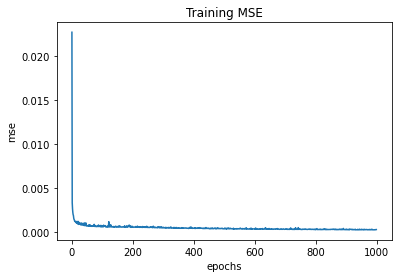

In [16]:
score = history.history['loss'][0]
print('training loss : ', score)

plt.plot(history.history['loss'])
plt.title('Training MSE')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.show()

Model Evaluation : 
MSE :  149.66773705647162
RMSE :  12.233876616039236


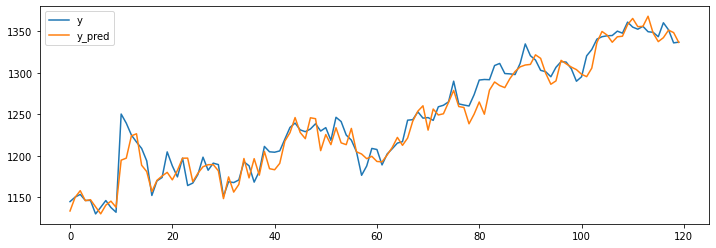

In [21]:
y_pred = model.predict(X)

# inverse transform the price
y = sc2.inverse_transform(y.reshape(len(y),1))
y_pred = sc2.inverse_transform(y_pred)

# calculate rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(y, y_pred)
rmse = sqrt(mse)
print('Model Evaluation : ')
print('MSE : ', mse) 
print('RMSE : ', rmse)

# plot the last 120 days prediction
plt.figure(figsize=(12,4))
plt.plot(y[-120:])
plt.plot(y_pred[-120:])
plt.legend(['y','y_pred'])
plt.show()

# Model Evaluation : walk forward validation

In [24]:
# get the test set : Jan - March of 2020
df = DataReader('GOOG', data_source='yahoo', start='2020-01-01', end='2020-03-31')
X1 = df.loc[:, ['Open']].values
X2 = df.loc[:, ['Close']].values

# feature scaling on the test set
sc1 = MinMaxScaler(feature_range = (0,1))
sc2 = MinMaxScaler(feature_range = (0,1))

X1 = sc1.fit_transform(X1)
X2 = sc2.fit_transform(X2)
test = np.concatenate((X1, X2), axis=1)

# seed the last n_steps in training dataset
history = data_scaled[-n_steps:]

# create timestep sequence for the training set
test = np.concatenate((history, test), axis=0)
X_test, y_test = create_sequence(test, n_steps)
y_test = y_test.reshape(y_test.shape[0],1)  

print('X_test shape : ',X_test.shape)
print('y_test shape : ',y_test.shape)

X_test shape :  (62, 60, 2)
y_test shape :  (62, 1)


In [0]:
# Make predictions
y_pred = model.predict(X_test)

In [0]:
# inverse transform y_test and y_pred 
y_test = sc2.inverse_transform(y_test)
y_pred = sc2.inverse_transform(y_pred)

Model Evaluation : 
MSE :  3455.4875121606933
RMSE :  58.78339486760435


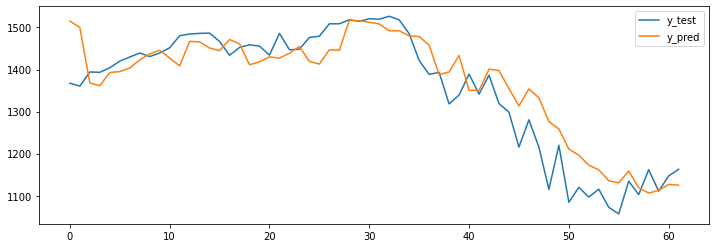

In [27]:
# calculate rmse
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print('Model Evaluation : ')
print('MSE : ', mse) 
print('RMSE : ', rmse)

# plot
plt.figure(figsize=(12,4))
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['y_test','y_pred'])
plt.show()